# Multi-Objective Optimization - 101

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deephyper/tutorials/blob/main/tutorials/colab/Multi_objective_optimization_101.ipynb)

In this tutorial, we will explore how to run black-box multi-objective optimization (MOO). In this setting, the goal is to resolve the following problem:

$$ \text{max}_x (f_0(x), f_1(x), ..., f_n(x)) $$

where $x$ is the set of optimized variables and $f_i$ are the different objectives. In DeepHyper, we use scalarization to transform such multi-objective problem into a single-objective problem:

$$ \text{max}_x s_w((f_0(x), f_1(x), ..., f_n(x))) $$

where $w$ is a set of weights which manages the trade-off between objectives and $s_w : \mathbb{R}^n \rightarrow \mathbb{R}$. The weight vector $w$ is randomized and re-sampled for each new batch of suggestion from the optimizer.



In [1]:
# Installing DeepHyper if not present
try:
    import deephyper
    print(deephyper.__version__)
except (ImportError, ModuleNotFoundError):
    !pip install deephyper

# Installing DeepHyper/Benchmark if not present
try:
    import deephyper_benchmark as dhb
except (ImportError, ModuleNotFoundError):
    !pip install -e "git+https://github.com/deephyper/benchmark.git@main#egg=deephyper-benchmark"

0.6.0


We will look at the DTLZ benchmark suite, a classic in multi-objective optimization (MOO) litterature. This benchmark exibit some characteristic cases of MOO. By default, this tutorial is loading the DTLZ-II benchmark which exibit a Pareto-Front with a concave shape.

In [2]:
import os

n_objectives = 2

# Configuration of the DTLZ Benchmark
os.environ["DEEPHYPER_BENCHMARK_DTLZ_PROB"] = str(2)
os.environ["DEEPHYPER_BENCHMARK_NDIMS"] = str(8)
os.environ["DEEPHYPER_BENCHMARK_NOBJS"] = str(n_objectives)
os.environ["DEEPHYPER_BENCHMARK_DTLZ_OFFSET"] = str(0.6)
os.environ["DEEPHYPER_BENCHMARK_FAILURES"] = str(0)

# Loading the DTLZ Benchmark
import deephyper_benchmark as dhb; dhb.load("DTLZ");
from deephyper_benchmark.lib.dtlz import hpo, metrics

We can display the variable search space of the benchmark we just loaded:

In [3]:
hpo.problem

Configuration space object:
  Hyperparameters:
    x0, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x1, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x2, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x3, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x4, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x5, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x6, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5
    x7, Type: UniformFloat, Range: [0.0, 1.0], Default: 0.5

To define a black-box for multi-objective optimization it is very similar to single-objective optimization at the difference that the `objective` can now be a list of values. A first possibility is:


```python
def run(job):
    ...
    return objective_0, objective_1, ..., objective_n
```

which just returns the objectives to optimize as a tuple. If additionnal metadata are interesting to gather for each evaluation it is also possible to return them by following this format:

```python
def run(job):
    ...
    return {
        "objective": [objective_0, objective_1, ..., objective_n],
        "metadata": {
            "flops": ...,
            "memory_footprint": ...,
            "duration": ...,
        }
    }
```
each of the metadata needs to be JSON serializable and will be returned in the final results with a column name formatted as `m:metadata_key` such as `m:duration`.

Now we can load Centralized Bayesian Optimization search:

In [4]:
from deephyper.search.hps import CBO
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import TqdmCallback

In [5]:
# Interface to submit/gather parallel evaluations of the black-box function.
# The method argument is used to specify the parallelization method, in our case we use threads.
# The method_kwargs argument is used to specify the number of workers and the callbacks.
# The TqdmCallback is used to display a progress bar during the search.
evaluator = Evaluator.create(
    hpo.run,
    method="thread",
    method_kwargs={"num_workers": 4, "callbacks": [TqdmCallback()]},
)

# Search algorithm
# The acq_func argument is used to specify the acquisition function.
# The multi_point_strategy argument is used to specify the multi-point strategy,
# in our case we use qUCB instead of the default cl_max (constant-liar) to reduce overheads.
# The update_prior argument is used to specify whether the sampling-prior should
# be updated during the search.
# The update_prior_quantile argument is used to specify the quantile of the lower-bound
# used to update the sampling-prior.
# The moo_scalarization_strategy argument is used to specify the scalarization strategy.
# Chebyshev is capable of generating a diverse set of solutions for non-convex problems.
# The moo_scalarization_weight argument is used to specify the weight of the scalarization.
# random is used to generate a random weight vector for each iteration.
search = CBO(
    hpo.problem,
    evaluator,
    acq_func="UCB",
    multi_point_strategy="qUCB",
    update_prior=True,
    update_prior_quantile=0.25,
    moo_scalarization_strategy="Chebyshev",
    moo_scalarization_weight="random",
    objective_scaler="quantile-uniform",
    n_jobs=-1,
    verbose=1,
)

# Launch the search for a given number of evaluations
# other stopping criteria can be used (e.g. timeout, early-stopping/convergence)
results = search.search(max_evals=500)

/Users/romainegele/Documents/Argonne/deephyper/deephyper/evaluator/_evaluator.py:127: UserWarning: Applying nest-asyncio patch for IPython Shell!
  warnings.warn(


  0%|          | 0/500 [00:00<?, ?it/s]

A Pandas table of results is returned by the search and also saved at `./results.csv`. An other location can be specified by using `CBO(..., log_dir=...)`.

In [6]:
results

,p:x0,p:x1,p:x2,p:x3,p:x4,p:x5,p:x6,p:x7,objective_0,objective_1,job_id,m:timestamp_submit,m:timestamp_gather,m:timestamp_start,m:timestamp_end,pareto_efficient
0,0.732801,0.258932,0.305273,0.328307,0.658982,0.484735,0.668014,0.780547,-5.423811e-01,-1.215473,1,0.040021,0.040846,1.692629e+09,1.692629e+09,False
1,0.598070,0.656997,0.781439,0.077205,0.758584,0.847639,0.447811,0.664212,-8.400465e-01,-1.148885,2,0.040031,0.044557,1.692629e+09,1.692629e+09,False
2,0.534563,0.210952,0.074239,0.748915,0.779246,0.621874,0.599470,0.423393,-1.010725e+00,-1.126896,0,0.040004,0.044697,1.692629e+09,1.692629e+09,False
3,0.966159,0.798987,0.260962,0.396474,0.912059,0.523443,0.470692,0.143307,-8.100098e-02,-1.522343,3,0.040041,0.044989,1.692629e+09,1.692629e+09,False
4,0.080390,0.821934,0.829348,0.206314,0.755824,0.490305,0.523823,0.060113,-1.577775e+00,-0.200302,7,0.195484,0.196034,1.692629e+09,1.692629e+09,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.000000,0.582467,0.605043,0.609493,0.613257,0.676911,0.597216,0.575153,-6.166949e-17,-1.007139,492,33.176538,33.177558,1.692630e+09,1.692630e+09,False
496,1.000000,0.596296,0.600745,0.596596,0.600390,0.636942,0.604646,0.620512,-6.134458e-17,-1.001833,498,33.436944,33.437334,1.692630e+09,1.692630e+09,False
497,1.000000,0.603369,0.669395,0.573112,0.642491,0.574909,0.594930,0.604284,-6.172398e-17,-1.008029,497,33.436936,33.437642,1.692630e+09,1.692630e+09,False
498,1.000000,0.594125,0.588445,0.624002,0.616879,0.570144,0.571049,0.595503,-6.140249e-17,-1.002779,499,33.436950,33.437795,1.692630e+09,1.692630e+09,False


In this table we retrieve:

- columns starting by `p:` which are the optimized variables.
- the `objective_{i}` are the objectives returned by the black-box function.
- the `job_id` is the identifier of the executed evaluations.
- columns starting by `m:` are metadata returned by the black-box function.
- `pareto_efficient` is a column only returned for MOO which specify if the evaluation is part of the set of optimal solutions.

Let us use this table to visualized evaluated objectives:

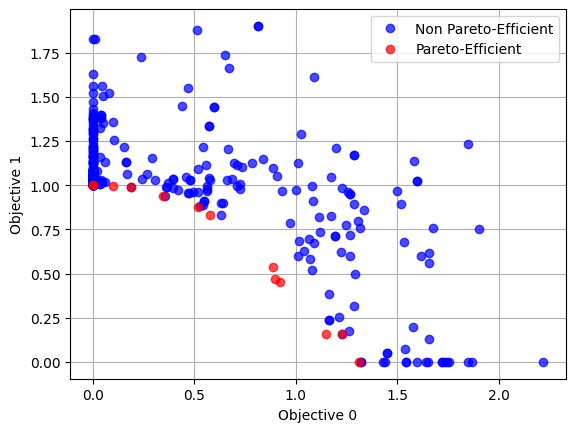

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(
    -results[~results["pareto_efficient"]]["objective_0"],
    -results[~results["pareto_efficient"]]["objective_1"],
    "o",
    color="blue",
    alpha=0.7,
    label="Non Pareto-Efficient",
)
plt.plot(
    -results[results["pareto_efficient"]]["objective_0"],
    -results[results["pareto_efficient"]]["objective_1"],
    "o",
    color="red",
    alpha=0.7,
    label="Pareto-Efficient",
)
plt.grid()
plt.legend()
plt.xlabel("Objective 0")
plt.ylabel("Objective 1")
plt.show()